In [277]:
%matplotlib inline
from time import sleep
import numpy as np 
import scipy
import os
import sys
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, confusion_matrix

from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.optimizers import RMSprop

from keras.layers.core import Dense, Dropout, Activation, Flatten


#Questions:
#question: Is there a better way to do the input than just flattening?


#Completed tasks
#Write a normal neural net to try to predict the next measurement with the window method in multiple dimensions (train_baseline_multi)
#Write a deep neural net to try to predict the next measurement with the window method in multiple dimensions (train_baseline_multi)
#Write a Random Forest Regressor to try to predict the next measurement with the window method in multiple dimensions (train_forest)
#Consolidate the pipeline - shape data / create models / validate models 
#Sliding window with a RNN to predict the next value (train_window_regression_rnn)
#Random Forest Classifier to classify FLAG at the next measurement(30 trees, 30 features)
#Neural Network Classifier (1 layer, 512 nodes) 
#Deep Neural Network Classifier (2 layers, 512 nodes) 
#Recurrent Neural Network for classification using window
#--------------------------------------------------------------------------------------------------------------------------------------------
#Completed today
#Complete all the quizzes and submit a request for MIMIC
#Sanity check for A = B
    #If it doesn't work, make sure the rolling/unrolling is correct
    #Switch order of patient and timestep
    #If it still doesn't work, try only feeding it one previous instead of 20 previous
#--------------------------------------------------------------------------------------------------------------------------------------------
#TODO 
#Investigate if any of our methods can actually predict in the time period where the flag is being flipped: e.g. the previous window has both 0 and 1
#Sequence to sequence rnn regression
#Sequence to sequence rnn classification
#Write a normal neural net to take prediction from rnn and predict 1/0
#Add a stateful try where the rnn is an autoencoder ( http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf) and then another LSTM

In [278]:
# fix random seed for reproducibility
np.random.seed(7)
V=np.random.randn(10)
print(V.dot(V), np.linalg.norm(V)**2)

8.33980975239 8.33980975239


In [300]:
#Setup for the generation of the data 
d=10 ##number of measurements per patient per time unit
k=2 ##complexity of the time series
n=200 ## number of patients
train_split = 10 ## number of patients training
len_sequence = 1
# stateful rnn has tsteps = 1
tsteps = 1
epochs = 25

T=175## amount of time measured for each patient (also batch size)
sigmaw=0.2 ##randomness
#d by d
U=np.random.randn(d,k).dot(np.random.randn(k,d))
betashift=np.random.randn(d)/np.sqrt(d)  ## used to check when we switch to the other time series
#normalized U
A=0.9*U/np.linalg.norm(U,ord=2)
#V is also d by d
V=np.random.randn(d,k).dot(np.random.randn(k,d))
#normalized V
B=.9*V/np.linalg.norm(V,ord=2)
B = A #Set B = A for sanity checking
X = np.zeros((n,T,d)) #this represents n patients, in d-dimensions, for T time-steps
Y = np.zeros((n,T - len_sequence,d)) #this is just X displaced by 1
flags = np.zeros(Y.shape)
flag=1

In [301]:
np.random.randn(d)

array([-1.16879446,  1.36846671,  0.40173198,  0.49696635, -0.38821552,
       -0.05680216, -0.0839445 ,  0.22113159,  0.65308208,  0.33509393])

In [302]:
#Generate the data, fill in X, Y, flags
flag_switches = []
for j in range(n): #for each patient
    X[j,0,:]=np.random.randn(d)/np.sqrt(d)
    flag=1
    flag_switch = -1
    for i in range(1,T): #for each time      
        if flag and ((X[j,i-1,:].dot(betashift))>.5): ##if flag was true and we go above a certain threshold, then set flag=0
            flag=0
            flag_switch = i
            flag_switches.append(flag_switch)
        ## we can think of flag has flag==1 means not critical, flag==0 means critical
        if flag:
            X[j,i,:]=A.dot(X[j,i-1,:])+sigmaw*np.random.randn(d)
        else:
            X[j,i,:]=B.dot(X[j,i-1,:])+sigmaw*np.random.randn(d)
    for i in range(0, T - len_sequence): #for each time
        Y[j, i, :] = X[j, i+len_sequence, :] #set the value of Y[j,i,:] to be X[j,i+len_sequence,:] (len_sequence in the future)
        if flag_switch >= 0: #if the flag ever switched
            flags[j, i, :] = (flag_switch <= i + len_sequence) * np.ones(flags[j,i,:].shape) #set flags            
X = X[:, 0:T-len_sequence, :]
## X is a n by d by T tensor
## Y is just X but shifted one backwards
## n represents independent trials (think of them as patients or time periods for patients separated)
## T represents the time horizon (how long we observe a patient, for now T is the same for everybody, but we can imagine that changing)
## d is the number of measurements that we have per patient per time.

In [303]:
#Format the data with a window of length 20

crazy = np.array([X[:, i: i + len_sequence] for i in range(X.shape[1] - len_sequence - 1)])
crazy_y = np.array([X[:, i + len_sequence + 1] for i in range(X.shape[1] - len_sequence - 1)])
crazy_flags = np.array([flags[:, i] for i in range(X.shape[1] - len_sequence - 1)])
oned_flags = np.array([flags[:, i, 0:1] for i in range(X.shape[1] - len_sequence - 1)])

print(crazy.shape)
print(crazy_y.shape)
print(crazy_flags.shape)
print(oned_flags.shape)

(172, 200, 1, 10)
(172, 200, 10)
(172, 200, 10)
(172, 200, 1)


In [304]:
def prepare_baseline():
    #Reshape data and flatten for baseline models
    rolled_x = crazy[:,:,:,:]
    rolled_y = crazy_y[:,:,:]

    print (rolled_x.shape)
    print (rolled_y.shape)

    unrolled_x = np.zeros((crazy.shape[0]*crazy.shape[1], crazy.shape[2] * crazy.shape[3]))
    unrolled_y = np.zeros((crazy.shape[0] * crazy.shape[1], crazy.shape[3]))

    for i in range(crazy.shape[1]): #patients
        for j in range(crazy.shape[0]): #time steps
            unrolled_y[i * crazy.shape[0] + j] = rolled_y[j,i,:]            
            for l in range(crazy.shape[3]):#dimensionality of data measurements
                for k in range(crazy.shape[2]): #len_sequence
                    unrolled_x[i * crazy.shape[0] + j][k*crazy.shape[3] + l] = rolled_x[j,i,k,l]

    print (unrolled_x.shape)
    print (unrolled_y.shape)

    X_train = np.array(unrolled_x[:25000,:])
    y_train = np.array(unrolled_y[:25000])
    X_test = np.array(unrolled_x[25000:,:])
    y_test = np.array(unrolled_y[25000:])

    print (X_train.shape)
    print (y_train.shape)
    print (X_test.shape)
    print (y_test.shape)
    
    return (X_train, y_train, X_test, y_test)

In [305]:
(X_train, y_train, X_test, y_test) = prepare_baseline()


(172, 200, 1, 10)
(172, 200, 10)
(34400, 10)
(34400, 10)
(25000, 10)
(25000, 10)
(9400, 10)
(9400, 10)


In [310]:
#Given a model that uses the flattened window, this will print its mean squared error and plot it's results versus reality
def analyze(model, X_test, y_test):
    plt.clf()
    results = model.predict(X_test)
    #only plotting the first 400 because otherwise you can't see anything
    
    manual = np.zeros((9400,10))
    for i in range(9400):
        manual[i,:] = A.dot(X_test[i,:])
        
    preds = results[4000:4100,:]
    reals = y_test[4000:4100,:]
    manuals = manual[4000:4100, :]
    plt.plot(preds, color='red')
    plt.plot(reals, color='blue')
    plt.plot(manuals, color='yellow')
    
    all_z = np.zeros((9400,10))
    
    print("all_zero error: " + str(mean_absolute_error(y_test, all_z)))
    print("smart_predictor error: " + str(mean_absolute_error(y_test, manual)))
    print("Actual Error: " + str(mean_absolute_error(y_test, results)))

In [286]:
#Given a model that uses the flattened window for classification,this will print its confusion matrix and plot it's results versus reality
def analyze_classification(model, X_test, y_test):
    results = model.predict(X_test)
    #only plotting the first 400 because otherwise you can't see anything
    preds = results[:400]
    reals = y_test[:400]
    plt.plot(preds, color='red')
    plt.plot(reals, color='blue')
    print(confusion_matrix(y_test, results))
    #Compare to all zeros
    """
    print("Try all zeros")
    zeros = np.zeros(5600)
    print(confusion_matrix(y_test, zeros))
    """

In [287]:
def train_forest(X_train, y_train):
    ne = [10]
    nf = [10]
    models = []
    for e in ne:
        for f in nf:   
            model = RandomForestRegressor(n_estimators=e, max_features = f, verbose=2)
            model.fit(X_train, y_train)
            models.append(model)
    return models

In [288]:
def train_baseline_nn(X_train, y_train, X_test, y_test):
    #Baseline model in multiple dimensions: predicts the next measurement, all 10 dimensions
    rms = RMSprop()
    model = Sequential()
    model.add(Dense(512, input_shape=(X_train.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(y_train.shape[1]))
    model.compile(loss='mean_squared_error', optimizer=rms)
    model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=1,
              validation_data=(X_test, y_test))
    return model

In [289]:
def train_baseline_multi_deep(X_train, y_train, X_test, y_test):
    #Baseline model in multiple dimensions: predicts the next measurement, all 10 dimensions
    rms = RMSprop()
    model = Sequential()
    model.add(Dense(512, input_shape=(X_train.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(y_train.shape[1]))
    model.compile(loss='mean_squared_error', optimizer=rms)
    model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=1,
              validation_data=(X_test, y_test))
    return model

In [290]:
#(X_train, y_train, X_test, y_test) = prepare_baseline()
models = {}
#tree_models = train_forest(X_train, y_train)
#models['tree'] = tree_models[0]
models['nn'] = train_baseline_nn(X_train, y_train, X_test, y_test)
#models['deep_nn'] = train_baseline_multi_deep(X_train, y_train, X_test, y_test)


Train on 25000 samples, validate on 9400 samples
Epoch 1/10
25000/25000 [==============================] - 2s - loss: 0.0451 - val_loss: 0.0446
Epoch 2/10
25000/25000 [==============================] - 2s - loss: 0.0446 - val_loss: 0.0445
Epoch 3/10
25000/25000 [==============================] - 2s - loss: 0.0445 - val_loss: 0.0445
Epoch 4/10
25000/25000 [==============================] - 2s - loss: 0.0444 - val_loss: 0.0445
Epoch 5/10
25000/25000 [==============================] - 2s - loss: 0.0443 - val_loss: 0.0445
Epoch 6/10
25000/25000 [==============================] - 2s - loss: 0.0443 - val_loss: 0.0445
Epoch 7/10
25000/25000 [==============================] - 2s - loss: 0.0443 - val_loss: 0.0444
Epoch 8/10
25000/25000 [==============================] - 3s - loss: 0.0443 - val_loss: 0.0445
Epoch 9/10
25000/25000 [==============================] - 4s - loss: 0.0443 - val_loss: 0.0444
Epoch 10/10
25000/25000 [==============================] - 4s - loss: 0.0443 - val_loss: 0.0445


In [296]:
X_test.shape

(9400, 10)

all_zero error: 0.166280089774
smart_predictor error: 0.168585674924
Actual Error: 0.166918574582


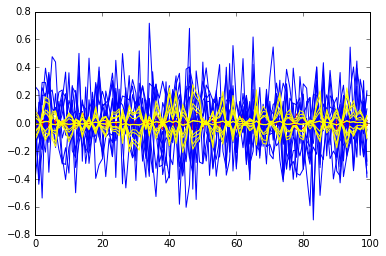

In [311]:
analyze(models['nn'], X_test, y_test)

In [238]:
def prepare_rnn():
    #Reshape data and flatten for baseline models
    rolled_x = crazy[:,:,:,:]
    rolled_y = crazy_y[:,:,:]

    print (rolled_x.shape)
    print (rolled_y.shape)

    unrolled_x = np.zeros((crazy.shape[0] * crazy.shape[1], crazy.shape[2], crazy.shape[3]))
    unrolled_y = np.zeros((crazy.shape[0] * crazy.shape[1], crazy.shape[3]))

    #maybe we should switch the order of these (but also maybe not it depends how batching works)
    for i in range(crazy.shape[0]): #time steps
        for j in range(crazy.shape[1]): #patients
            unrolled_x[i * crazy.shape[1] + j] = rolled_x[i,j,:,:]
            unrolled_y[i * crazy.shape[1] + j] = rolled_y[i,j,:]            

    print (unrolled_x.shape)
    print (unrolled_y.shape)

    X_train = np.array(unrolled_x[:25000,:])
    y_train = np.array(unrolled_y[:25000])
    X_test = np.array(unrolled_x[25000:,:])
    y_test = np.array(unrolled_y[25000:])

    print (X_train.shape)
    print (y_train.shape)
    print (X_test.shape)
    print (y_test.shape)
    
    return (X_train, y_train, X_test, y_test)
    

In [239]:
(X_train, y_train, X_test, y_test) = prepare_rnn()

(154, 200, 10, 10)
(154, 200, 10)
(30800, 10, 10)
(30800, 10)
(25000, 10, 10)
(25000, 10)
(5800, 10, 10)
(5800, 10)


In [240]:
#Predict the next measurement.  Trained using the window method.  A GRU + a Dense layer
def train_window_regression_rnn(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(GRU(16,activation='relu', input_dim = d))
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(d))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=1,
              validation_data=(X_test, y_test))
    return model

In [241]:
rnn_regressor = train_window_regression_rnn(X_train, y_train, X_test, y_test)

Train on 25000 samples, validate on 5800 samples
Epoch 1/10
25000/25000 [==============================] - 4s - loss: 0.0451 - val_loss: 0.0442
Epoch 2/10
25000/25000 [==============================] - 4s - loss: 0.0449 - val_loss: 0.0441
Epoch 3/10
25000/25000 [==============================] - 4s - loss: 0.0448 - val_loss: 0.0441
Epoch 4/10
25000/25000 [==============================] - 4s - loss: 0.0448 - val_loss: 0.0441
Epoch 5/10
25000/25000 [==============================] - 4s - loss: 0.0448 - val_loss: 0.0440
Epoch 6/10
25000/25000 [==============================] - 4s - loss: 0.0448 - val_loss: 0.0440
Epoch 7/10
25000/25000 [==============================] - 4s - loss: 0.0448 - val_loss: 0.0440
Epoch 8/10
25000/25000 [==============================] - 4s - loss: 0.0448 - val_loss: 0.0440
Epoch 9/10
25000/25000 [==============================] - 4s - loss: 0.0447 - val_loss: 0.0440
Epoch 10/10
25000/25000 [==============================] - 4s - loss: 0.0447 - val_loss: 0.0440


All Zero error: 0.167545578338
Actual Error: 0.167065875155


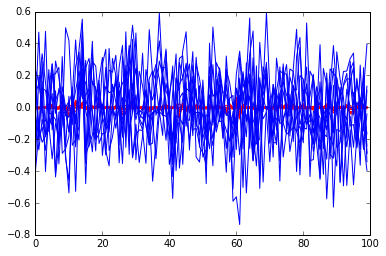

In [242]:
analyze(rnn_regressor, X_test, y_test)

In [243]:
def prepare_classification_rnn():
    #Reshape data and flatten for baseline models
    rolled_x = crazy[:,:,:,:]
    rolled_y = oned_flags[:,:,:]

    print (rolled_x.shape)
    print (rolled_y.shape)

    unrolled_x = np.zeros((crazy.shape[0] * crazy.shape[1], crazy.shape[2], crazy.shape[3]))
    unrolled_y = np.zeros((crazy.shape[0] * crazy.shape[1]))

    #maybe we should switch the order of these (but also maybe not it depends how batching works)
    for i in range(crazy.shape[0]): #time steps
        for j in range(crazy.shape[1]): #patients
            unrolled_x[i * crazy.shape[1] + j] = rolled_x[i,j,:,:]
            unrolled_y[i * crazy.shape[1] + j] = rolled_y[i,j,:]            

    print (unrolled_x.shape)
    print (unrolled_y.shape)

    X_train = np.array(unrolled_x[:25000,:])
    y_train = np.array(unrolled_y[:25000])
    X_test = np.array(unrolled_x[25000:,:])
    y_test = np.array(unrolled_y[25000:])

    print (X_train.shape)
    print (y_train.shape)
    print (X_test.shape)
    print (y_test.shape)
    
    return (X_train, y_train, X_test, y_test)
    

In [244]:
def prepare_classification_baseline():
    #Reshape data and flatten for baseline models
    rolled_x = crazy[:,:,:,:]
    rolled_y = oned_flags[:,:,:]

    print (rolled_x.shape)
    print (rolled_y.shape)
    unrolled_x = np.zeros((crazy.shape[0]*crazy.shape[1], crazy.shape[2] * crazy.shape[3]))
    unrolled_y = np.zeros((crazy.shape[0] * crazy.shape[1]))

    for i in range(crazy.shape[0]): #time steps
        for j in range(crazy.shape[1]): #patients
            unrolled_y[i * crazy.shape[1] + j] = rolled_y[i,j,:]            
            for l in range(crazy.shape[3]):#dimensionality of data measurements
                for k in range(crazy.shape[2]): #len_sequence
                    unrolled_x[i * crazy.shape[1] + j][k*crazy.shape[3] + l] = rolled_x[i,j,k,l]

    print (unrolled_x.shape)
    print (unrolled_y.shape)

    X_train = np.array(unrolled_x[:25000,:])
    y_train = np.array(unrolled_y[:25000])
    X_test = np.array(unrolled_x[25000:,:])
    y_test = np.array(unrolled_y[25000:])

    print (X_train.shape)
    print (y_train.shape)
    print (X_test.shape)
    print (y_test.shape)
    
    return (X_train, y_train, X_test, y_test)

In [245]:
def train_classification_forest(X_train, y_train):
    ne = [10]
    nf = [10]
    models = []
    for e in ne:
        for f in nf:   
            model = RandomForestClassifier(n_estimators=e, max_features = f, verbose=2)
            model.fit(X_train, y_train)
            models.append(model)
    return models

In [246]:
(X_train, y_train, X_test, y_test) = prepare_classification_baseline()

(154, 200, 10, 10)
(154, 200, 1)
(30800, 100)
(30800,)
(25000, 100)
(25000,)
(5800, 100)
(5800,)


In [247]:
models = train_classification_forest(X_train, y_train)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.8s finished


num_estimators: 10
Max Features: 10
[[ 287  211]
 [1107 4195]]


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


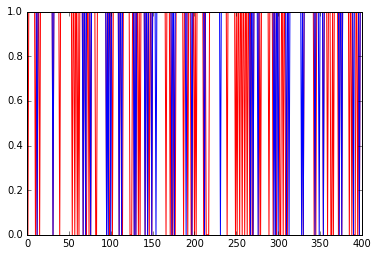

In [248]:
for m in models: 
    print ("num_estimators: " + str(m.n_estimators))
    print ("Max Features: " + str(m.max_features))
    analyze_classification(m, X_test, y_test)

In [249]:
def train_window_classification_nn(X_train, y_train, X_test, y_test):
    #Baseline model in multiple dimensions: predicts the next measurement, all 10 dimensions
    rms = RMSprop()
    model = Sequential()
    model.add(Dense(512, input_shape=(X_train.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=1,
              validation_data=(X_test, y_test))    
    return model

In [250]:
model = train_window_classification_nn(X_train, y_train, X_test, y_test)

Train on 25000 samples, validate on 5800 samples
Epoch 1/10
25000/25000 [==============================] - 2s - loss: 0.5018 - acc: 0.7584 - val_loss: 0.2583 - val_acc: 0.9410
Epoch 2/10
25000/25000 [==============================] - 2s - loss: 0.2599 - acc: 0.9103 - val_loss: 0.1584 - val_acc: 0.9541
Epoch 3/10
25000/25000 [==============================] - 2s - loss: 0.1932 - acc: 0.9316 - val_loss: 0.1156 - val_acc: 0.9648
Epoch 4/10
25000/25000 [==============================] - 2s - loss: 0.1587 - acc: 0.9451 - val_loss: 0.0965 - val_acc: 0.9678
Epoch 5/10
25000/25000 [==============================] - 2s - loss: 0.1349 - acc: 0.9546 - val_loss: 0.0816 - val_acc: 0.9724
Epoch 6/10
25000/25000 [==============================] - 2s - loss: 0.1159 - acc: 0.9608 - val_loss: 0.0781 - val_acc: 0.9731
Epoch 7/10
25000/25000 [==============================] - 2s - loss: 0.1028 - acc: 0.9661 - val_loss: 0.0932 - val_acc: 0.9662
Epoch 8/10
25000/25000 [==============================] - 2s -

[1 1 1 ..., 0 1 1]
[[ 466   32]
 [ 144 5158]]


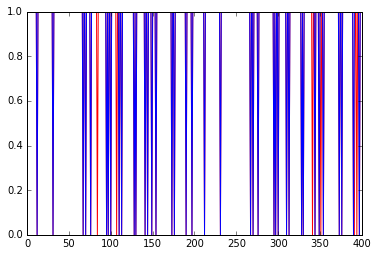

In [251]:
results = model.predict(X_test)[:,0]
results = np.where(results>.5, 1, 0)
print (results)
#only plotting the first 400 because otherwise you can't see anything
preds = results[:400]
reals = y_test[:400]

plt.plot(preds, color='red')
plt.plot(reals, color='blue')
print(confusion_matrix(y_test, results))
#Compare to all zeros

In [252]:
def train_window_classification_deep_nn(X_train, y_train, X_test, y_test):
    #Baseline model in multiple dimensions: predicts the next measurement, all 10 dimensions
    rms = RMSprop()
    model = Sequential()
    model.add(Dense(512, input_shape=(X_train.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=1,
              validation_data=(X_test, y_test))    
    return model

In [253]:
model2 = train_window_classification_deep_nn(X_train, y_train, X_test, y_test)

Train on 25000 samples, validate on 5800 samples
Epoch 1/10
25000/25000 [==============================] - 7s - loss: 0.4015 - acc: 0.8068 - val_loss: 0.1269 - val_acc: 0.9581
Epoch 2/10
25000/25000 [==============================] - 7s - loss: 0.2010 - acc: 0.9226 - val_loss: 0.0885 - val_acc: 0.9660
Epoch 3/10
25000/25000 [==============================] - 7s - loss: 0.1514 - acc: 0.9425 - val_loss: 0.1045 - val_acc: 0.9555
Epoch 4/10
25000/25000 [==============================] - 7s - loss: 0.1190 - acc: 0.9548 - val_loss: 0.1036 - val_acc: 0.9564
Epoch 5/10
25000/25000 [==============================] - 7s - loss: 0.1014 - acc: 0.9618 - val_loss: 0.0849 - val_acc: 0.9641
Epoch 6/10
25000/25000 [==============================] - 7s - loss: 0.0882 - acc: 0.9666 - val_loss: 0.0999 - val_acc: 0.9602
Epoch 7/10
25000/25000 [==============================] - 7s - loss: 0.0744 - acc: 0.9718 - val_loss: 0.0862 - val_acc: 0.9652
Epoch 8/10
25000/25000 [==============================] - 7s -

[1 1 1 ..., 0 1 1]
[[ 446   52]
 [  83 5219]]


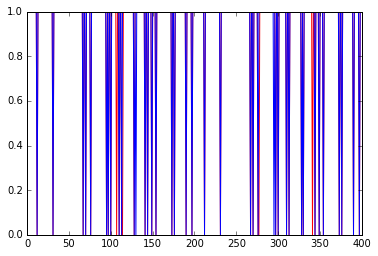

In [254]:
results = model2.predict(X_test)[:,0]
results = np.where(results>.5, 1, 0)
print (results)
#only plotting the first 400 because otherwise you can't see anything
preds = results[:400]
reals = y_test[:400]

plt.plot(preds, color='red')
plt.plot(reals, color='blue')
print(confusion_matrix(y_test, results))
#Compare to all zeros

In [255]:
#Predict the next measurement.  Trained using the window method.  A GRU + a Dense layer
def train_window_classification_rnn(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(GRU(16,activation='relu', input_dim = d))
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=1,
              validation_data=(X_test, y_test))
    return model

In [256]:
(X_train, y_train, X_test, y_test) = prepare_classification_rnn()

(154, 200, 10, 10)
(154, 200, 1)
(30800, 10, 10)
(30800,)
(25000, 10, 10)
(25000,)
(5800, 10, 10)
(5800,)


In [257]:
model = train_window_classification_rnn(X_train, y_train, X_test, y_test)

Train on 25000 samples, validate on 5800 samples
Epoch 1/10
25000/25000 [==============================] - 3s - loss: 0.5723 - acc: 0.6835 - val_loss: 0.2734 - val_acc: 0.8684
Epoch 2/10
25000/25000 [==============================] - 3s - loss: 0.3064 - acc: 0.8696 - val_loss: 0.1082 - val_acc: 0.9517
Epoch 3/10
25000/25000 [==============================] - 4s - loss: 0.2087 - acc: 0.9188 - val_loss: 0.1021 - val_acc: 0.9574
Epoch 4/10
25000/25000 [==============================] - 3s - loss: 0.1715 - acc: 0.9345 - val_loss: 0.1116 - val_acc: 0.9522
Epoch 5/10
25000/25000 [==============================] - 3s - loss: 0.1492 - acc: 0.9449 - val_loss: 0.1906 - val_acc: 0.9150
Epoch 6/10
25000/25000 [==============================] - 3s - loss: 0.1338 - acc: 0.9495 - val_loss: 0.0795 - val_acc: 0.9662
Epoch 7/10
25000/25000 [==============================] - 3s - loss: 0.1206 - acc: 0.9550 - val_loss: 0.0989 - val_acc: 0.9571
Epoch 8/10
25000/25000 [==============================] - 3s -

[1 1 1 ..., 0 1 1]
[[ 472   26]
 [ 111 5191]]


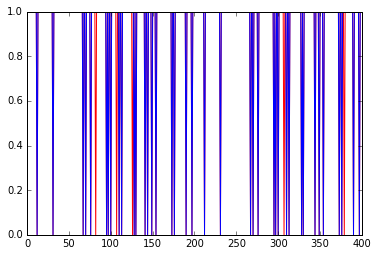

In [258]:
results = model.predict(X_test)[:,0]
results = np.where(results>.5, 1, 0)
print (results)
#only plotting the first 400 because otherwise you can't see anything
preds = results[:400]
reals = y_test[:400]

plt.plot(preds, color='red')
plt.plot(reals, color='blue')
print(confusion_matrix(y_test, results))
#Compare to all zeros

In [ ]:
#EVERYTHING BELOW HERE IS NOT WORKING / OLD CODE

In [ ]:
#given train_split, train the model using the first train_split examples
#which = 0 for the normal prediction
#which = 1 for crazy_flags
#which = 2 for oned_flags
def train_stage1(train_split, which):
    #First model: Using the sliding window
    hists = []
    model = Sequential()
    model.add(GRU(128,activation='relu', input_shape=(crazy.shape[2:])))
    if which == 2:
        model.add(Dense(1))
    else:
        model.add(Dense(d))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(train_split): # for each patient
        this_patient_x = crazy[:,i,:,:]
        if which == 0:
            this_patient_y = crazy_y[:,i,:]
        elif which == 1:
            this_patient_y = crazy_flags[:,i,:]
        else:
            this_patient_y = oned_flags[:,i,0:1]
        for ii in range(crazy.shape[0]): #for each window of time sequence
            this_patient_x_i = np.array([this_patient_x[ii,:,:]])
            if which == 2:
                this_patient_y_i = np.array([this_patient_y[ii,0:1]])
            else:
                this_patient_y_i = np.array([this_patient_y[ii,:]])
            hists.append(model.train_on_batch(this_patient_x_i, this_patient_y_i))
        model.reset_states()
    return hists, model

In [ ]:
def train_stage2(train_split):
    #second model: trading a stateful rnn using this batch thing
    hists = []
    model = Sequential()
    
    X  # this is our input data, of shape (32, 21, 16)
    # we will feed it to our model in sequences of length 10

    model = Sequential()
    model.add(LSTM(32, batch_input_shape=(32, 10, 16), stateful=True))
    model.add(Dense(16, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

    # we train the network to predict the 11th timestep given the first 10:
    model.train_on_batch(X[:, :10, :], np.reshape(X[:, 10, :], (32, 16)))

    # the state of the network has changed. We can feed the follow-up sequences:
    model.train_on_batch(X[:, 10:20, :], np.reshape(X[:, 20, :], (32, 16)))

    # let's reset the states of the LSTM layer:
    model.reset_states()

    # another way to do it in this case:
    model.layers[0].reset_states()
    
    model.add(GRU(128,activation='relu', input_shape=(crazy.shape[2:])))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(train_split): # for each patient
        this_patient_x = crazy[:,i,:,:]
        if which == 0:
            this_patient_y = crazy_y[:,i,:]
        elif which == 1:
            this_patient_y = crazy_flags[:,i,:]
        else:
            this_patient_y = oned_flags[:,i,0:1]
        for ii in range(crazy.shape[0]): #for each window of time sequence
            this_patient_x_i = np.array([this_patient_x[ii,:,:]])
            if which == 2:
                this_patient_y_i = np.array([this_patient_y[ii,0:1]])
            else:
                this_patient_y_i = np.array([this_patient_y[ii,:]])
            hists.append(model.train_on_batch(this_patient_x_i, this_patient_y_i))
        model.reset_states()
    return hists, model

In [ ]:
oned_flags.shape
(hists, model) = train_stage1(10, 2)

In [ ]:
#compare the y between them
print(oned_flags[:, 0, 0:1].shape)
#this is y for normal stuff
print(crazy_y[:,i,:][0,:].shape)
#this is y for the newest one
print((oned_flags[:,0,0:1][0,0:1]).shape)
#compare the x between them


In [ ]:
print(crazy[:, patient_num, :, :].shape)
print((crazy[:,0,:,:][0,:,:]).shape)

crazy[:,patient_num,:,:]

In [ ]:
#evaluate the model on the last 10 samples
#which = 0 for the normal prediction
#which = 1 for crazy_flags
#which = 2 for oned_flags
def evaluate(model, which):
    evaluations = []
    for i in range(n-10, n): # for each patient not in the training
        this_patient_x = crazy[:,i,:,:]
        if which == 0:
            this_patient_y = crazy_y[:,i,:]
        elif which == 1:
            this_patient_y = crazy_flags[:,i,:]
        else:
            this_patient_y = oned_flags[:,i,:]
        for ii in range(crazy.shape[0]): #for each window of time sequence
            this_patient_x_i = np.array([this_patient_x[ii,:,:]])            
            this_patient_y_i = np.array([this_patient_y[ii,:]])
            evaluations.append(model.evaluate(this_patient_x_i, this_patient_y_i, verbose=0))
        model.reset_states()
    return evaluations

In [ ]:
histories = {}
all_evals = {}
which = 2
for training_amount in range(10, 100, 10):
    #Train the model
    (hists, model) = train_stage1(training_amount, which)

    #Check training results of the data
    hist_values = []
    for hist in hists:
        hist_values.append(hist.item())
    #plt.plot(hist_values)
    histories[training_amount] = (sum(hist_values)/float(len(hist_values)))

    #Check evaluation of the model
    evaluations = evaluate(model, which)
    #plt.plot(evaluations)
    all_evals[training_amount] = (sum(evaluations)/float(len(evaluations)))

In [ ]:
print(histories)
for key in histories:
    print (key)
    print (histories[key] - all_evals[key])
print(all_evals)

In [ ]:
#Visually check the prediction of the first reading versus what's actually happening
#(178, 200, 20, 10)

#choose a patient
patient_num = randint(101,199)
#choose a measuremen
measurement = 0

#Get what we are aiming for
if which == 0:
    reality = crazy_y[:, patient_num, measurement]
elif which == 1:
    reality = crazy_flags[:, patient_num, measurement]
elif which == 2:
    reality = oned_flags[:, patient_num, 0:1]
#Get the predictions
model.reset_states()
predictions = model.predict(crazy[:,patient_num,:,:])

#Plot prediction versus reality
plt.plot(predictions[:,0], color='red')
plt.plot(reality, color='blue')

In [ ]:
#Compute MSE
dif = reality - predictions[:,0]
dif = dif ** 2
print ("MSE:")
print (sum(dif)/178)

#Plot the difference
plt.plot(dif)